# K-nearest neighbors

We are using the [CIFAR 10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset.
You can download with `wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz`
After downloading `cifar-10-python.tar.gz` to this folder run `tar -xvf cifar-100-python.tar.gz`


In [1]:
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



def distance(ndarr1, ndarr2):
    return (np.sum((ndarr1 - ndarr2) ** 2)).item() ** .5



In [2]:
train = unpickle('cifar-10-batches-py/data_batch_1')
test = unpickle('cifar-10-batches-py/test_batch')
train[b'data'] = train[b'data'] / 255
test[b'data'] = test[b'data'] / 255


train_data = train[b'data']
train_labels = train[b'labels']

test_data = test[b'data'][:1000]
test_labels = test[b'labels'][:1000]

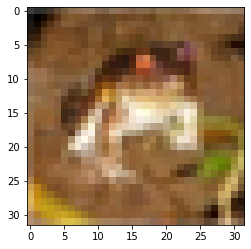

In [3]:
# Output a sample image
from matplotlib.pyplot import imshow

sample = train_data[0]


def convertTensor(sample):
    size = 32 * 32
    r = sample[:size].reshape((32, 32))
    g = sample[size:2*size].reshape((32, 32))
    b = sample[2*size:].reshape((32, 32))
    
    return np.dstack((r, g, b))

    
imshow(convertTensor(sample))

In [4]:
# Define k nearest neighbors algorithm
import heapq 
from collections import Counter
from statistics import mode

class LabeledDistance:  #https://stackoverflow.com/questions/2501457/what-do-i-use-for-a-max-heap-implementation-in-python
  def __init__(self, distance, label): 
      self.distance = distance
      self.label = label
  def __lt__(self, other):
      return self.distance > other.distance
  def __eq__(self, other):
      return self.distance == other.distance
  def __str__(self): return f"Label: {self.label} Distance: {self.distance}"

class MaxHeap:
  def __init__(self): self.h = []
  def heappush(self, d, l): heapq.heappush(self.h, LabeledDistance(d, l))
  def heappop(self): return heapq.heappop(self.h)
  def __len__(self): return len(self.h)      
  def __getitem__(self, i): return self.h[i]

  @staticmethod
  def print_list(list_of_labeled):            
        print([str(labeled) for labeled in list_of_labeled])
  def get_majority(self):
      sorted_by_distance = sorted(self.h, reverse=True)
      return mode([ld.label for ld in sorted_by_distance])
    




def find_label(test_sample, train, k=1, silent=True):
    smallest = MaxHeap()

    for sample, label in zip(train[b'data'], train[b'labels']):
        # Do not consider this sample if the distance is bigger than the biggest of the smallest        
        # However, if the maxheap is not full yet, insert anyway
        if len(smallest) != 0 and distance(test_sample, sample) >= smallest[0].distance and len(smallest) >= k:
            continue
        
        if len(smallest) == k:
            smallest.heappop() # remove the worst value

        smallest.heappush(distance(test_sample, sample), label)
    
    if not silent:
        print('Nearest neighbors (sorted by least distance):')
        for ld in sorted(smallest.h, reverse=True):
            print(f'Label: {ld.label}')
        
    return smallest.get_majority()
    




In [5]:
# Define testing algorithm
from IPython.display import clear_output

DEBUG = False

def test_classifier(k=1):
    correct = 0
    total = 0
    for sample, label in zip(test_data, test_labels):
        if total % 25 == 0:
            clear_output(wait=True)
        if DEBUG and (total + 1) % 11 == 0:
            clear_output(wait=True)
            return correct / total
        
        print(f'Testing no. {total + 1}')        
        pred = find_label(sample, train, k=k)
        if pred == label:   
            correct += 1
        total += 1
        
    clear_output(wait=True)
    return correct / total


In [6]:
# a) Error rate for k = 1
1 - test_classifier()

0.7170000000000001

In [7]:
# b) Error rate = for k = [2, 5, 10, 20]
import pandas as pd

history = {'k_vals': [2, 5, 10, 20], 'accuracy': []}

for k in history['k_vals']:
    history['accuracy'].append(test_classifier(k=k))
    
print(history)

{'k_vals': [2, 5, 10, 20], 'accuracy': [0.283, 0.306, 0.302, 0.302]}


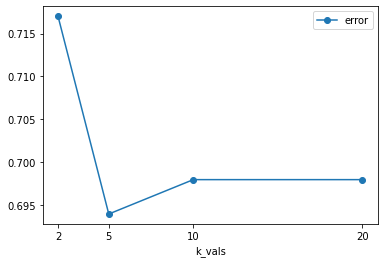

In [8]:
# b) Plot for error rates
import matplotlib.pyplot as plt
history_pd = pd.DataFrame(history)

history_pd['error'] = 1 - history_pd['accuracy']
history_pd.k_vals = history_pd.k_vals.astype(int)

history_pd.plot(y='error', x='k_vals', marker='o')
plt.gca().set_xticks(history_pd["k_vals"].unique())

plt.show()

In [9]:
# c) Pick a random image from test data and report its 10 nearest neighbors
np.random.seed(42)
labels = np.array(test_labels)

for label_no in range(10):
    print(f'\n\nClass: {label_no}')
    index = np.random.choice(np.where(labels == label_no)[0])
    find_label(test_data[index], train, k=10, silent=False)
    




Class: 0
Nearest neighbors (sorted by least distance):
Label: 0
Label: 0
Label: 3
Label: 3
Label: 4
Label: 2
Label: 2
Label: 4
Label: 6
Label: 2


Class: 1
Nearest neighbors (sorted by least distance):
Label: 1
Label: 0
Label: 1
Label: 8
Label: 8
Label: 0
Label: 9
Label: 1
Label: 1
Label: 2


Class: 2
Nearest neighbors (sorted by least distance):
Label: 2
Label: 4
Label: 6
Label: 4
Label: 6
Label: 6
Label: 4
Label: 3
Label: 5
Label: 4


Class: 3
Nearest neighbors (sorted by least distance):
Label: 5
Label: 2
Label: 3
Label: 2
Label: 6
Label: 5
Label: 3
Label: 6
Label: 3
Label: 6


Class: 4
Nearest neighbors (sorted by least distance):
Label: 0
Label: 0
Label: 0
Label: 2
Label: 2
Label: 2
Label: 2
Label: 2
Label: 0
Label: 0


Class: 5
Nearest neighbors (sorted by least distance):
Label: 2
Label: 8
Label: 2
Label: 2
Label: 4
Label: 8
Label: 8
Label: 8
Label: 1
Label: 7


Class: 6
Nearest neighbors (sorted by least distance):
Label: 6
Label: 6
Label: 6
Label: 9
Label: 6
Label: 1
Label: 